<font size="5"> **Mixed layer depth in the Southern Ocean** </font>  
  
This script produces plots of Mixed Layer Depth (MLD) around the Southern Ocean using outputs from ACCESS-OM2-01. It also compares model outputs to observations.
  
**Requirements:** It is suggested you use the `conda/analysis3-20.07` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe
import rioxarray
from scipy.io import loadmat

The following modules are used in plotting maps and time series.

In [2]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm                  
import cartopy.crs as ccrs            
import cartopy.feature as cft         
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [5]:
session = cc.database.create_session()

This notebook uses outputs for the second cycle, v140 run of ACCESS-OM2-01, which includes wind forcing. A list of ACCESS-OM2-01 experiments can be accessed using `cc.querying.get_experiments(session)`. A detailed list of experiments can be obtained by adding the following argument: `all = True`.

## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [4]:
varDict =  {'var_id': 'mld',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'mixed layer depth',
             'short_name': 'MLD',
             'unit': 'm',
             'CICE_data': False,
             'base_data': r'/g/data/v45/la6889/Calculations/MLD/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/MLD/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/MLD/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/MLD/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/MLD/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/MLD/ClippedMEASOregions/',
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/MLD/DecadalSeasonal/Means',
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/MLD/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones',
             'res': '0.1°'}

## Accessing ACCESS-OM2 outputs and saving results to disk

In [49]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = False)
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'MixedLayerDepth_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

## Loading MEASO regions to overlay them on plots

<AxesSubplot:>

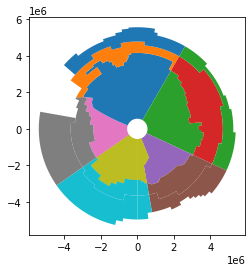

In [ ]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Add a column with the long name for each MEASO area
MEASO = MEASO.assign(long_name = (MEASO.sector + ' ' + MEASO.zone).to_list())

#Checking results
MEASO.plot(column = 'long_name')

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [ ]:
clim_overall = zsf.climCalc(SO, [1979, 2008], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])
clim_seasonal = zsf.climCalc(SO, [1979, 2008], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])
clim_monthly = zsf.climCalc(SO, [1979, 2008], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

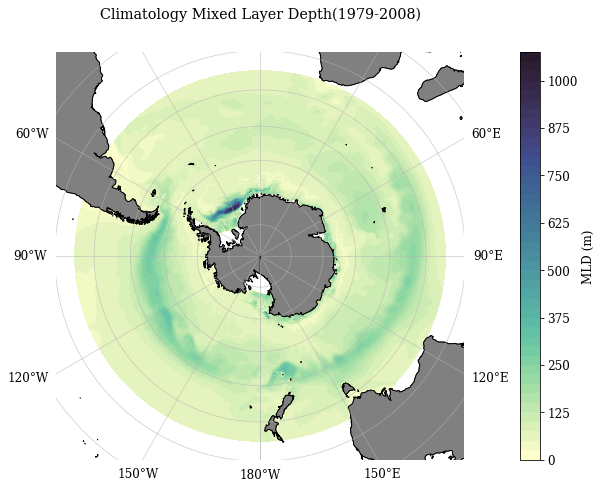

In [121]:
filepath = glob(os.path.join(varDict['climatologies'], '*overall*.nc'))

clim_overall = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Setting color palette levels
maxv = np.ceil(float(clim_overall.max().values))+25
levels = np.arange(0, maxv, 25)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.deep, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = (varDict['short_name'] + ' (' + varDict['unit'] + ')'), pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

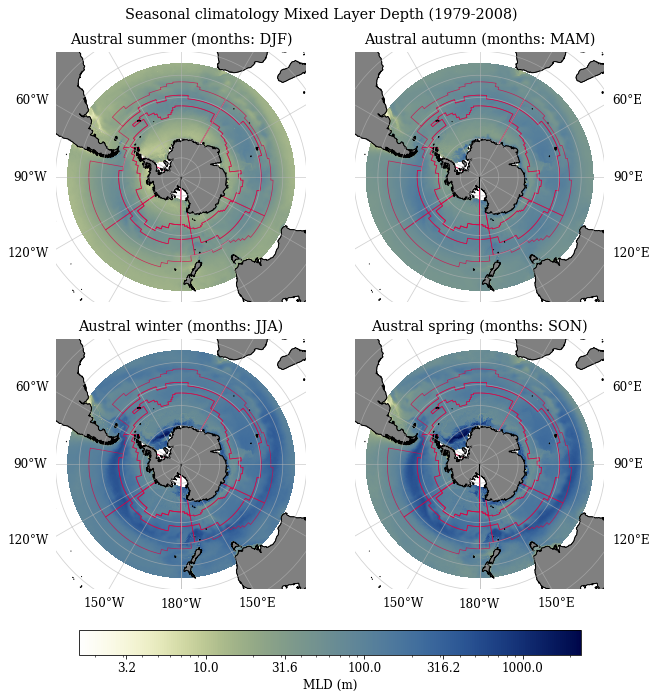

In [156]:
#Get full path for seasonal climatology
filepath = glob(os.path.join(varDict['climatologies'], '*seasonal*.nc'))

#Load data
clim_seasonal = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Create log scale for colorbar
log_norm = mcolors.LogNorm(vmin = clim_seasonal.min().values, 
                           vmax = clim_seasonal.max().values)
#Create a list for ticks
cbar_ticks = [10**i for i in np.arange(np.floor(np.log10(clim_seasonal.min().values)),
                                       np.ceil(np.log10(clim_seasonal.max().values)), 0.5)]

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#Ensure labels created using LaTeX appear as regular text
plt.rcParams.update({'mathtext.default': 'regular'})

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

#Initialise list to save figure axes
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
        
    #Extract information for each season and start plotting
    p1 = clim_seasonal.sel(season = season).\
    plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                    #Use colormap created at the beginning of the block and apply log-transformed colormap
                    cmap = cmap_r, norm = log_norm,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    #Overlay MEASO regions
    MEASO.plot(color = 'none', lw = 0.7, ax = ax[season], edgecolor = '#dd0044',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, 
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')
#Show colorbar ticks
cb.set_ticks(cbar_ticks)
cb.set_ticklabels(np.round(cbar_ticks, 1))
    
fig.suptitle('Seasonal climatology ' + varDict['long_name'].title() + ' (1979-2008)',
             y = 0.93)

fn = 'SeasonalClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Loading observations for comparison
Observations come from [Sallee et al 2021](https://doi.org/10.1038/s41586-021-03303-x).

In [5]:
from scipy.io import loadmat
fn = r'/g/data/v45/la6889/MLD_Stratification_1970_2018.mat'
obs = loadmat(fn)

In [35]:
lon = obs['out']['LONGITUDE']
lat = obs['out']['LATITUDE']